In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# The dataset

In [2]:
X = np.load('./raw_data/X.npy')
y = np.load('./raw_data/y.npy')

In [3]:
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')

X.shape = (25000, 10, 3)
y.shape = (25000,)


__Comments__:

- the shape (25000, 10, 3) means:
    - 25000 employees
    - 10 points (years) of data
    - 3 types of data (salary, responsibility and company size) 

Let's look at the data of the first employee

In [4]:
employee_0 = pd.DataFrame(X[0],
                         columns=['salary',
                                 'responsibility',
                                 'company_size'])

round(employee_0, 2)

,salary,responsibility,company_size
0,0.80,10.73,102.0
1,0.50,10.73,102.0
2,0.60,10.73,102.0
3,0.71,10.73,130.0
4,0.94,10.73,130.0
5,1.05,10.73,130.0
6,1.12,32.00,108.0
7,4.87,32.00,108.0
8,4.97,33.00,108.0
9,5.20,39.00,108.0


__goal__: predict the monthly salary on the 11th year for each of these 25,000 employees, based on the past observations

In [5]:
# for example, the first employee earns 6.499 k USD per month durin the 11th year at the company
y[0]

6.499

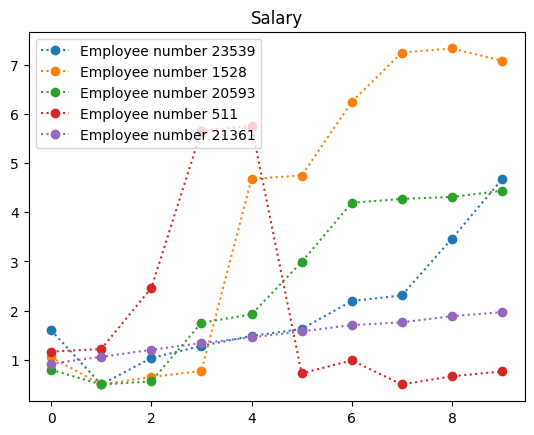

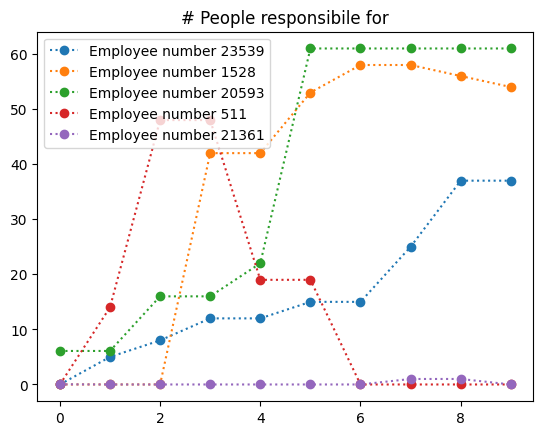

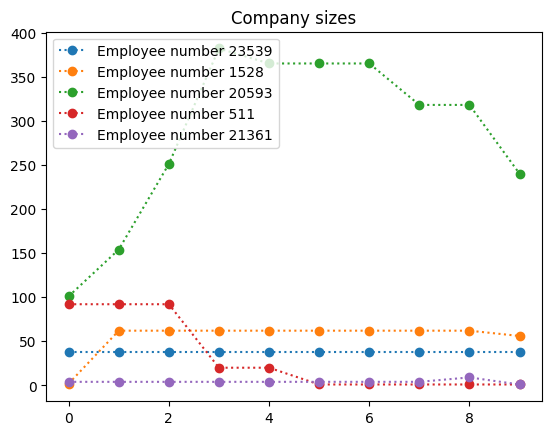

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

number_of_employees = len(X)

### Choosing random employees
##### As the employees are selected randomly, feel free to re-run this cell a few times !

number_of_randomly_selected_employees = 5

random_selection = np.random.randint(0, 
                                     number_of_employees,
                                     number_of_randomly_selected_employees)


### Plotting data for the selected employees

plt.title('Salary')
for r in random_selection:
    plt.plot(X[r, :, 0],label=f"Employee number {r}",linestyle=":",marker="o")
    plt.legend(loc='upper left')
plt.show()

plt.title('# People responsibile for')
for r in random_selection:
    plt.plot(X[r, :, 1],label=f"Employee number {r}",linestyle=":",marker="o")
    plt.legend(loc='upper left')
plt.show()

plt.title('Company sizes')
for r in random_selection:
    plt.plot(X[r, :, 2],label=f"Employee number {r}",linestyle=":",marker="o")
    plt.legend(loc='upper left')
plt.show()

__Data exploration__ Looking a the distribution of:

- all the salaries during the 10th year
- people under someone's responsibility
- and the company sizes

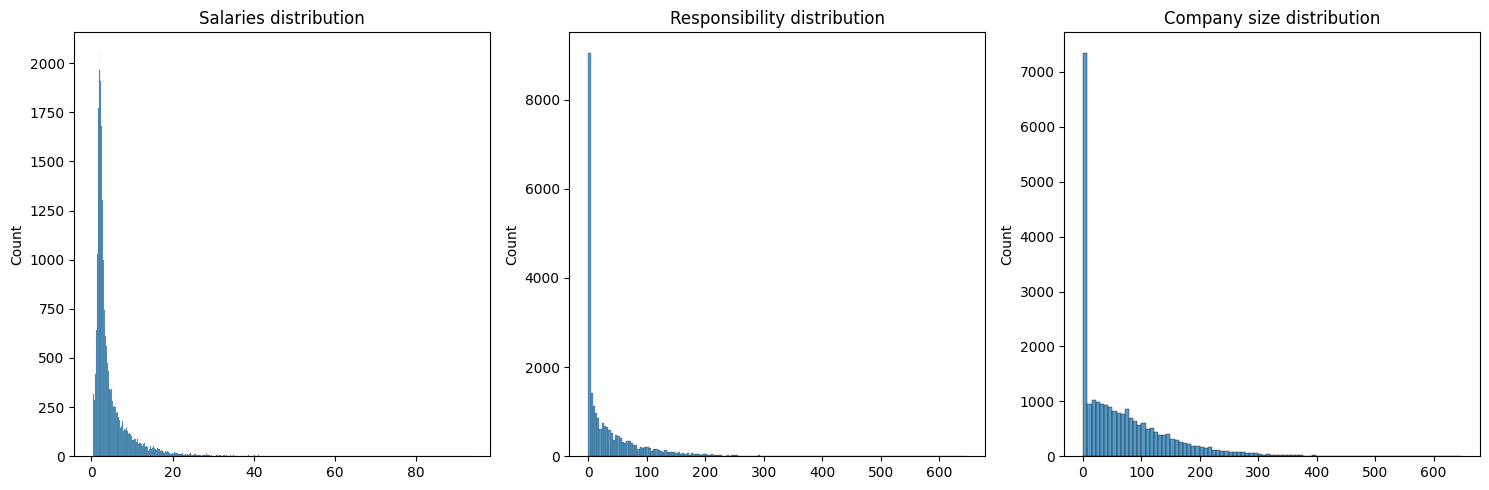

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

# distribution of all salaries during the 10th year
sns.histplot(X[:, -1, 0], ax=axs[0])
axs[0].set_title('Salaries distribution')

# distribution of responsibility during the 10th year
sns.histplot(X[:, -1, 1], ax=axs[1])
axs[1].set_title('Responsibility distribution')

# distribution of company size during the 10th year
sns.histplot(X[:, -1, 2], ax=axs[2])
axs[2].set_title('Company size distribution')

plt.tight_layout()
plt.show()